# Example notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import netCDF4
import numpy as np
import os, sys
import pandas as pd

# Data import

- paths

In [2]:
os.chdir("/Users/schmidle/Documents/GIT-Projects/DeepHydro")
data_folder = 'Datasample'
data_prec = '01_prec_data_sample.nc'
data_temp = '01_temp_data_sample.nc'
data_disc = '01_discharge_sample.csv'

- read output data

In [3]:
df = pd.read_csv(os.path.join(data_folder, data_disc))
df.head()

Unnamed: 0        Time    Q
0       27455  1950-01-01  558
1       27456  1950-01-02  547
2       27457  1950-01-03  541
3       27458  1950-01-04  541
4       27459  1950-01-05  564

In [4]:
def plot_streamflow(df, n_labels=10):
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Q'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(n_labels)) # limit number of dates on x axis
    fig.autofmt_xdate() # rotate data labels
    plt.show()
    

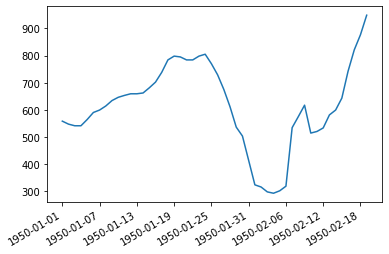

In [5]:
plot_streamflow(df)

- read input data (NetCDF4)

In [6]:
def read_data(filename, folder):
    import netCDF4
    dat = netCDF4.Dataset(os.path.join(folder, filename))
    print(filename)
    arr = np.array(dat.variables['variable'])
    mask = arr < 0
    arr[ mask ] = 0.0
    return arr, mask

def plot_frame(temp:np.array, prec:np.array, mask:np.array, df:pd.DataFrame, frame:int):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    im_t = np.ma.masked_array(temp[frame], mask=mask[frame])
    im_p = np.ma.masked_array(prec[frame], mask=mask[frame])
    
    ax[0].set_title('Temperature')
    cb1 = ax[0].imshow(im_t)
    fig.colorbar(cb1, ax=ax[0], orientation='horizontal')

    ax[1].set_title('Precipitation')
    cb2 = ax[1].imshow(im_p)
    fig.colorbar(cb2, ax=ax[1], orientation='horizontal')
    
    for a in ax: a.axis('off')


In [7]:
temp, mask = read_data(data_temp, data_folder)
prec, mask = read_data(data_prec, data_folder)

01_temp_data_sample.nc
01_prec_data_sample.nc


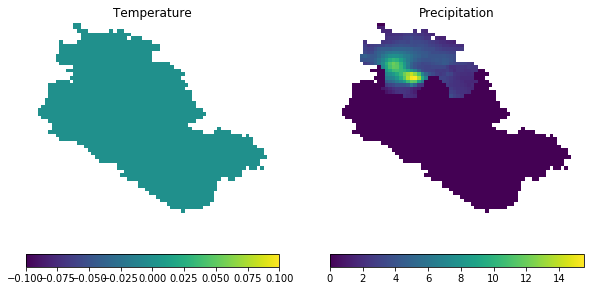

In [8]:
plot_frame(temp, prec, mask, df, frame=0)

# Data preparation

- standardize output data (`y`)

In [9]:
def standardize(data:np.array, return_moments=False):
    mean = np.mean(data)
    std = np.std(data)
    if return_moments:
        return (data-mean)/std, mean, std
    else:
        return (data-mean)/std

Shape of y =  (50,)


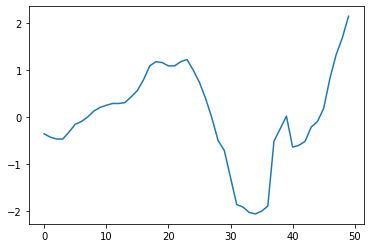

In [10]:
y, Y_MEAN, Y_STD = standardize(df['Q'].values, return_moments=True)
print('Shape of y = ', y.shape)

# plot data
plt.plot(y)

- standardize and combine input image (`x`)

Shape of x =  (50, 53, 66, 2)


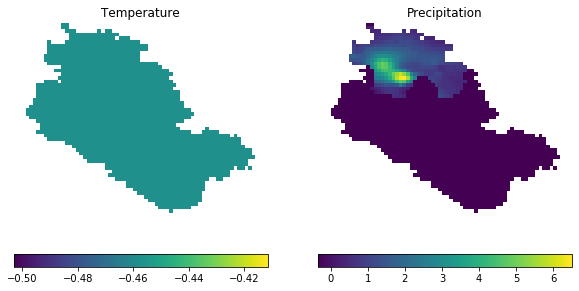

In [11]:
x_t = standardize(temp)
x_p = standardize(prec)
x = np.stack([x_t, x_p], axis=-1)
print('Shape of x = ', x.shape)

# plot sample frame
plot_frame(x_t, x_p, mask, df, frame=0)

- split train and test set

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [13]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_test  = ', x_test.shape)
print('Shape of y_test  = ', y_test.shape)


Shape of x_train =  (37, 53, 66, 2)
Shape of y_train =  (37,)
Shape of x_test  =  (13, 53, 66, 2)
Shape of y_test  =  (13,)


# Model

- just a simple stupid model...
- predicts the streamflow directly from temperature and precipitation of the same day...

In [14]:
def get_model(input_shape:tuple, n_layers:int=4, n_filters:int=32):
    
    from keras import layers, models
    print(input_shape)
    i = layers.Input(shape=input_shape)
    x = i
    for _ in range(n_layers):
        x = layers.Conv2D(n_filters, kernel_size=(3,3), strides=(2,2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        n_filters *= 2
        
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    o = layers.Dense(1, activation='linear')(x)
    return models.Model(inputs=[i], outputs=[o])

def build_model(model):
    from keras import optimizers, losses, metrics
    
    model.compile(optimizer=optimizers.Adam(lr=1e-3),
                 loss=losses.mse)
                 #metrics=[metrics.mse])

In [15]:
model = get_model(x_train.shape[1:])
build_model(model)
model.summary()

Using TensorFlow backend.


(53, 66, 2)







Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 53, 66, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 32, 32)        608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 15, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 15, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 12, 

# Training

In [16]:
n_epochs = 20
batch_size = 4

In [17]:
history = model.fit(x_train, y_train, 
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test))

Train on 37 samples, validate on 13 samples
Epoch 1/20
37/37 [==============================] - 1s 27ms/step - loss: 2.2439 - val_loss: 2.7148
Epoch 2/20
37/37 [==============================] - 0s 6ms/step - loss: 1.4620 - val_loss: 3.5084
Epoch 3/20
37/37 [==============================] - 0s 6ms/step - loss: 1.0986 - val_loss: 0.8243
Epoch 4/20
37/37 [==============================] - 0s 6ms/step - loss: 1.3422 - val_loss: 1.9750
Epoch 5/20
37/37 [==============================] - 0s 4ms/step - loss: 0.8447 - val_loss: 0.9031
Epoch 6/20
37/37 [==============================] - 0s 4ms/step - loss: 0.8743 - val_loss: 1.4863
Epoch 7/20
37/37 [==============================] - 0s 7ms/step - loss: 0.6444 - val_loss: 1.2301
Epoch 8/20
37/37 [==============================] - 0s 6ms/step - loss: 1.0198 - val_loss: 1.6303
Epoch 9/20
37/37 [==============================] - 0s 6ms/step - loss: 0.8616 - val_loss: 0.8650
Epoch 10/20
37/37 [==============================] - 0s 6ms/step - loss: 

In [18]:
def plot_history(history):
    nr = len(history.history.keys())
    fig, ax = plt.subplots(nr, 1, figsize=(6,3*nr), sharex=True)
    fig.tight_layout(h_pad=0)
    ax = ax.flatten()
    for i, key in enumerate(history.history.keys()):
        print(key)
        ax[i].plot(history.history[key], label=key)
        ax[i].legend()
    ax[i].set_xlabel('epoch')
    plt.show()

val_loss
loss


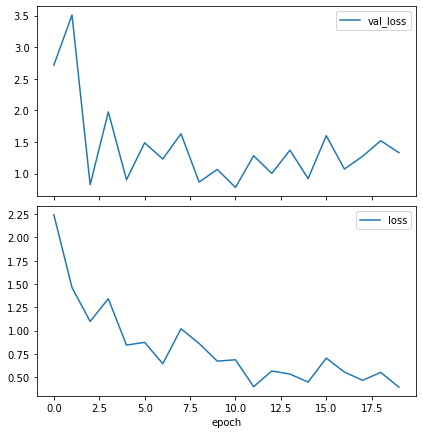

In [19]:
plot_history(history)

# Predict

In [20]:
def predict(model, image, gt=None):
    
    im = image[np.newaxis, ...] # add batch dimension

    t = im[..., 0] # get temperature
    p = im[..., 1] # get precipitation
    plot_frame(t, p, mask, df, 0) 

    y_pred = model.predict(im)[0,0] # get first element

    # calculate back to original units
    y_pred = Y_MEAN + y_pred * Y_STD
    
    if gt is not None:
        y_true = Y_MEAN + gt * Y_STD
        
        print(f'Predicted streamflow = {y_pred:.1f}, ground truth = {y_true:.1f}')
        return y_pred, y_true
    else:
        print(f'Predicted streamflow = {y_pred:.1f}')
        return y_pred

Predicted streamflow = 284.1, ground truth = 564.0


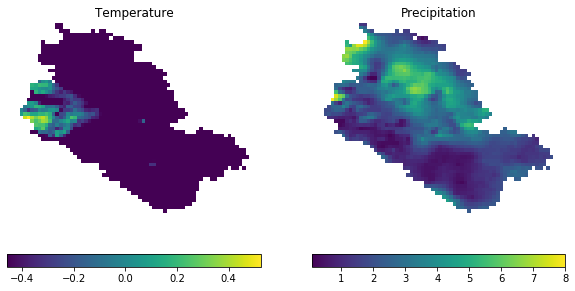

In [21]:
random_test_sample = np.random.randint(0, len(x_test))
_ = predict(model, x_test[random_test_sample], gt=y_test[random_test_sample])